In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/drive/My Drive/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
def prepareData(df, type='train'):
    # Removing un-necessary data
    p_id = df['PassengerId']
    if type == 'train':
        df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Survived']]    # We removed Cabin because out of 891 entries 687 were null (> 15%)
    elif type=='test':
        df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']]
    df['Cabin'] = df['Cabin'].fillna(0)
    df['Fare'] = df['Fare'] / (df['SibSp'] + df['Parch'] + 1)
    # df['family_count'] = df['SibSp'] + df['Parch'] + 1
    df = df.drop(['SibSp', 'Parch', 'Cabin'], axis=1)
    # df.head()

    # Conversion of String data to categorical data

    # Gender
    df['Sex'] = pd.get_dummies(df['Sex'])['female']    # We are taking female as 1 and male as 0(since it would be easy while submission)
    
    # Class
    p_class = pd.get_dummies(df['Pclass'])
    df['Class1'], df['Class2'], df['Class3'] = p_class[1], p_class[2], p_class[3]
    df = df.drop(['Pclass'], axis=1)

    sns.boxplot(df['Age'])
    plt.show()
    sns.boxplot(df['Fare'])
    plt.show()

    # Checking for NaN
    if df['Age'].isna().sum() > 0 or df['Fare'].isna().sum > 0:
        df['Age'].fillna(df['Age'].mean(), inplace=True)
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
    # Filling NaN with the mean of the Age (mean can be used since the pulling by the outliers isn't much)
    # But for Fare we replace with median since the outliers are pulling and making the distribution skew

    # Feature Scaling for faster loss convergence
    scaler = StandardScaler()
    df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])

    return df, p_id

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


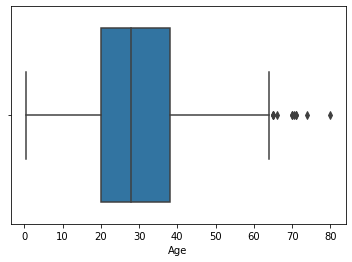

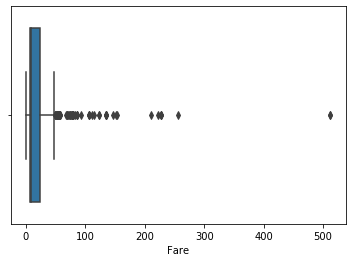

<bound method Series.mean of 0     -0.454798
1      0.438994
2     -0.334757
3      0.185187
4     -0.331267
         ...   
886   -0.193081
887    0.281499
888   -0.392335
889    0.281499
890   -0.339642
Name: Fare, Length: 891, dtype: float64>


,Sex,Age,Fare,Survived,Class1,Class2,Class3
0,0,-0.592481,-0.454798,0,0,0,1
1,1,0.638789,0.438994,1,1,0,0
2,1,-0.284663,-0.334757,1,0,0,1
3,1,0.407926,0.185187,1,1,0,0
4,0,0.407926,-0.331267,0,0,0,1


In [0]:
df, p_id = prepareData(df)
print(df['Fare'].mean)
df.head()

In [0]:
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, accuracy_score

def model_training(clf, x_t, y_t, x_v=None, y_v=None, model='binary:logistic'):
    clf.fit(x_t, y_t)
    print('Training Accuracy: ', clf.score(x_t, y_t))

    if model=='binary:logistic':
      print('Validation Accuracy', clf.score(x_v,y_v))
      print('Validation f1_score',f1_score(clf.predict(x_v),y_v))
      print('Validation roc_auc score',roc_auc_score(y_v,clf.predict_proba(x_v)[::,-1]))
      print('Confusion Matrix \n',confusion_matrix(y_v, clf.predict(x_v)))
    
    if model=='reg:linear':
        if x_v!=None:
            print('Validation r2_score', clf.score(x_v,y_v))
            print('Validation MSE',mean_squared_error(clf.predict(x_v),y_v))

            
    return clf

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

survived = df['Survived']
df = df.drop(['Survived'], axis=1)
x_t, x_v, y_t, y_v = train_test_split(df, survived, test_size=0.2, random_state=42)

lgr = LogisticRegression()
xgb = XGBClassifier(n_estimators=500, max_depth=5,learning_rate=0.1,scale_pos_weight=1.4266790777602751)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=1)

In [0]:
model = model_training(xgb, x_t, y_t, x_v, y_v)    # Training the XGBoost model

Training Accuracy:  0.9606741573033708
Validation Accuracy 0.8324022346368715
Validation f1_score 0.8026315789473683
Validation roc_auc score 0.8564993564993565
Confusion Matrix 
 [[88 17]
 [13 61]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


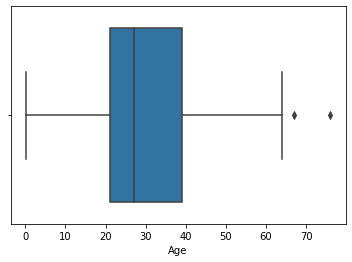

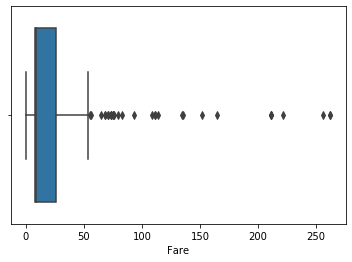

,Sex,Age,Fare,Class1,Class2,Class3
0,0,0.334993,-0.392110,0,0,1
1,1,1.325530,-0.513853,0,0,1
2,0,2.514175,-0.339852,0,1,0
3,0,-0.259330,-0.368677,0,0,1
4,1,-0.655545,-0.497098,0,0,1


In [0]:
# Testing the model with the test data
test = pd.read_csv('/content/drive/My Drive/titanic/test.csv')
test, ids = prepareData(test, type='test')
test.head()

In [0]:
y_pred = model.predict(test)

# Saving the predictions to csv
result = pd.DataFrame()
result['PassengerId'] = pd.Series(ids)
result['Survived'] = pd.Series(y_pred)
result.to_csv('submission.csv', index=False)